***

# Hierarchical Bayesian Modeling

In Part 1, we used Ridge/Lasso to create a pooled model that ignored neighborhood differences.
In Part 2, we used a Bayesian Global model, which quantified uncertainty but still treated the city as a monolith.

This brings us to the core of this project: **Hierarchical Modeling**.

Real estate markets are inherently hierarchical. Houses exist within neighborhoods, and neighborhoods exist within the city. A "No-Pooling" approach (independent regressions for each neighborhood) fails for small neighborhoods like *Landmark* $(n=1)$ or *Green Hills* $(n=2)$. A "Complete Pooling" approach (Part 1 & 2) ignores the premium of living in *Northridge*.

**The Solution: Partial Pooling**

We construct a hierarchical model where neighborhood parameters are not independent, but are drawn from a common city-wide distribution. This allows for **shrinkage**: the model "borrows strength" from data-rich neighborhoods to improve estimates for data-poor neighborhoods.

### Model Specification

We model the `Log_Sale_Price` ($y_{ij}$) for house $i$ in neighborhood $j$.

*   **Level 1 (House Level):**
    $$ y_{ij} | \theta_j, \sigma^2 \sim \mathcal{N}(\theta_j, \sigma^2) $$
    Each neighborhood $j$ has its own mean valuation $\theta_j$.
*   **Level 2 (Neighborhood Level):**
    $$ \theta_j | \mu, \tau^2 \sim \mathcal{N}(\mu, \tau^2) $$
    The neighborhood means are drawn from a global distribution with city-wide mean $\mu$ and between-neighborhood variance $\tau^2$.
*   **Level 3 (Hyperpriors):**
    $$ \mu \sim \mathcal{N}(12, 100) $$
    $$ \sigma^{-2}, \tau^{-2} \sim \text{Gamma}(0.1, 0.1) $$

This structure allows the model to learn the "Global Mean" ($\mu$) and the "Neighborhood Deviation" ($\tau$) simultaneously.

***

In [1]:
# --- Setup and Path Definition ---
import sys
from pathlib import Path

# Find the project root by looking for the .git folder
PROJECT_ROOT = Path.cwd().resolve().parents[2]

# Define key paths
DATA_PATH = PROJECT_ROOT / "src" / "data"
SRC_PATH = PROJECT_ROOT / "src"

# Add the 'src' directory to sys.path to allow for module imports
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Path:    {DATA_PATH}")
# --- End of Setup ---

Project Root: /Users/Faheem/Desktop/IITH/Sem 5 Textbooks and Extras/Bayesian/Project 2
Data Path:    /Users/Faheem/Desktop/IITH/Sem 5 Textbooks and Extras/Bayesian/Project 2/src/data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(DATA_PATH / 'processed' / 'post_eda_ames_data.csv')

In [3]:
from scipy import stats

# --- Prepare Data for Hierarchical Model ---
# Group data by neighborhood
grouped_data = df.groupby('Neighborhood')['Log_Sale_Price']

# Create a list of numpy arrays, one for each neighborhood
y_groups = [group.values for name, group in grouped_data]
neighborhood_names = [name for name, group in grouped_data]

# Get group-level statistics
y_bar_j = np.array([np.mean(group) for group in y_groups])
n_j = np.array([len(group) for group in y_groups])
m = len(y_groups)
N = np.sum(n_j)

# --- Priors ---
# Hyperpriors for mu, v, u
mu0, sigma0_sq = 12.0, 100.0
av, bv = 0.1, 0.1
au, bu = 0.1, 0.1

# --- Gibbs Sampler Settings ---
n_samples = 10000
burn_in = 2000

# --- Initialize Chains ---
theta_j_samples = np.zeros((n_samples, m))
mu_samples = np.zeros(n_samples)
v_samples = np.zeros(n_samples) # Precision 1/sigma^2
u_samples = np.zeros(n_samples) # Precision 1/tau^2

# Start values
theta_j_curr = y_bar_j.copy()
mu_curr = np.mean(theta_j_curr)
v_curr = 1.0 / np.mean([np.var(g) for g in y_groups])
u_curr = 1.0 / np.var(theta_j_curr)

print("Overall data mean:", df['Log_Sale_Price'].mean())
print("Group-means are:", y_bar_j)
print("Mean of group-means (y_bar_j):", np.mean(y_bar_j))
print("Var of group-means (np.var(y_bar_j)):", np.var(y_bar_j, ddof=1))
print("Initial v_curr (within precision):", v_curr)
print("Initial u_curr (between precision):", u_curr)

# --- Run Sampler ---
for i in range(n_samples):
    # 1. Update theta_j for each group j
    for j in range(m):
        Sj_sq = 1 / (n_j[j] * v_curr + u_curr)
        Mj = Sj_sq * (v_curr * n_j[j] * y_bar_j[j] + u_curr * mu_curr)
        theta_j_curr[j] = stats.norm.rvs(loc=Mj, scale=np.sqrt(Sj_sq))
    
    # 2. Update mu
    S_mu_sq = 1 / (1/sigma0_sq + m * u_curr)
    M_mu = S_mu_sq * (mu0/sigma0_sq + u_curr * np.sum(theta_j_curr))
    mu_curr = stats.norm.rvs(loc=M_mu, scale=np.sqrt(S_mu_sq))
    
    # 3. Update v (within-group precision)
    sum_sq_err_within = np.sum([np.sum((y_groups[j] - theta_j_curr[j])**2) for j in range(m)])
    Av = av + N / 2
    Bv = bv + 0.5 * sum_sq_err_within
    v_curr = stats.gamma.rvs(a=Av, scale=1/Bv)
    
    # 4. Update u (between-group precision)
    sum_sq_err_between = np.sum((theta_j_curr - mu_curr)**2)
    Au = au + m / 2
    Bu = bu + 0.5 * sum_sq_err_between
    u_curr = stats.gamma.rvs(a=Au, scale=1/Bu)

    # Store samples
    theta_j_samples[i, :] = theta_j_curr
    mu_samples[i] = mu_curr
    v_samples[i] = v_curr
    u_samples[i] = u_curr
    
# Discard burn-in
theta_j_post = theta_j_samples[burn_in:, :]
mu_post = mu_samples[burn_in:]
sigma2_post = 1 / v_samples[burn_in:] # within-group variance
tau2_post = 1 / u_samples[burn_in:]   # between-group variance

print("Hierarchical Model Gibbs sampler finished.")

Overall data mean: 12.020975245392643
Group-means are: [12.17891322 11.85626072 11.56092535 11.69085566 12.21797886 12.18160133
 12.19598174 11.7263833  12.14552901 12.52634495 12.16720725 11.47406177
 11.8277435  11.44999704 11.96640036 11.86372302 11.85227382 12.67341079
 12.63902871 12.12704101 11.67259591 11.81039859 12.08642278 12.31552708
 11.78607407 12.62167617 12.37834378 12.38884513]
Mean of group-means (y_bar_j): 12.049340890435904
Var of group-means (np.var(y_bar_j)): 0.12214271942654381
Initial v_curr (within precision): 16.557952643926253
Initial u_curr (between precision): 8.490371279646409
Hierarchical Model Gibbs sampler finished.


=== Neighborhood Statistics Summary ===
                           Neighborhood  Raw_Mean  Hierarchical_Mean  Num_Houses  Hierarchical_SD  Deviation_from_Global  CI_Lower  CI_Upper  CI_Width
                             Northridge 12.673411          12.668241          71         0.031213               0.623274 12.606175 12.728674  0.122499
                     Northridge_Heights 12.639029          12.637129         166         0.020611               0.588892 12.596588 12.677669  0.081081
                            Stone_Brook 12.621676          12.615944          51         0.036828               0.571540 12.543156 12.685908  0.142752
                            Green_Hills 12.526345          12.426508           2         0.168133               0.476209 12.091718 12.755346  0.663628
                                Veenker 12.388845          12.381211          24         0.054012               0.338709 12.277266 12.487011  0.209745
                             Timberland 12.378344     

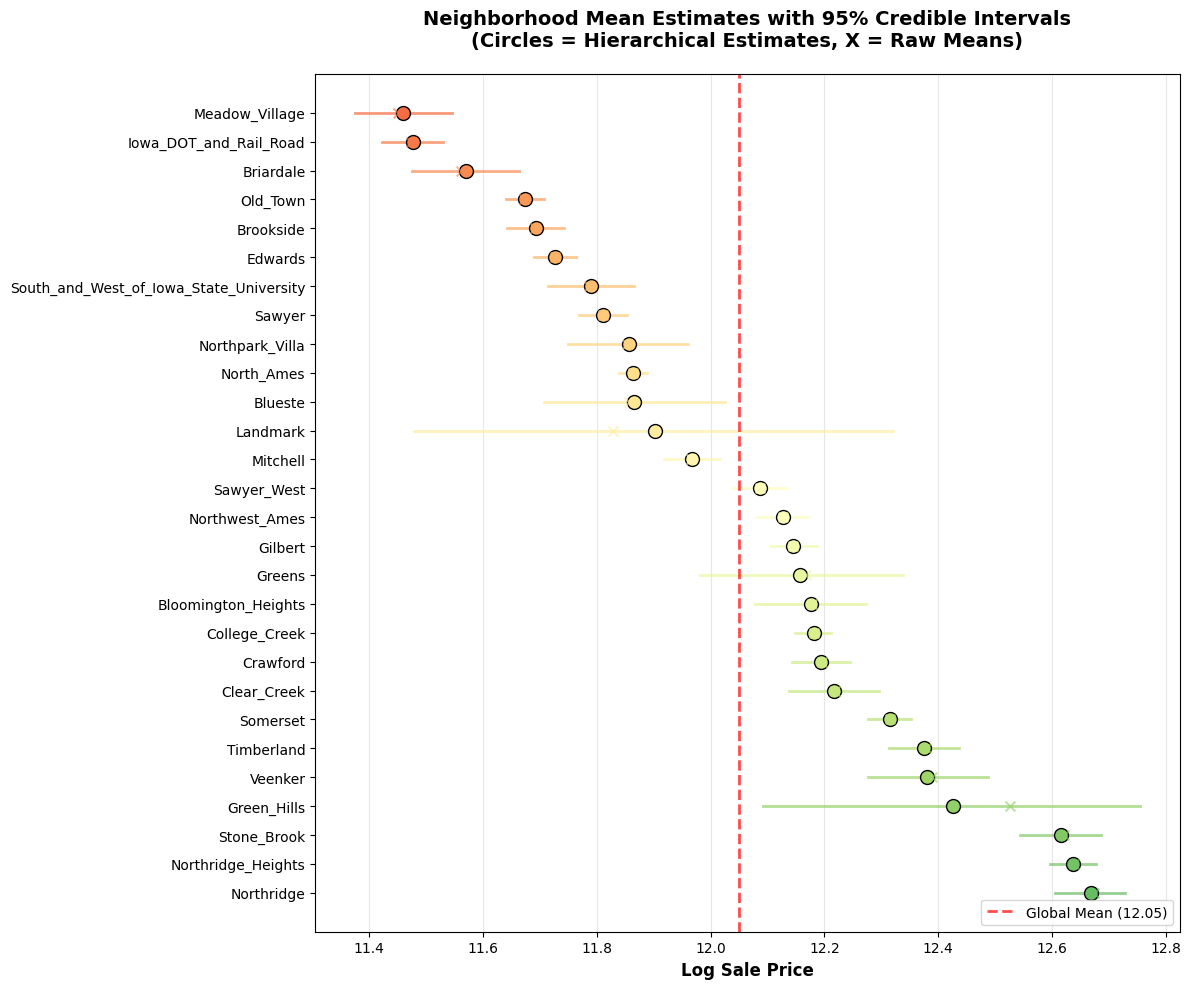

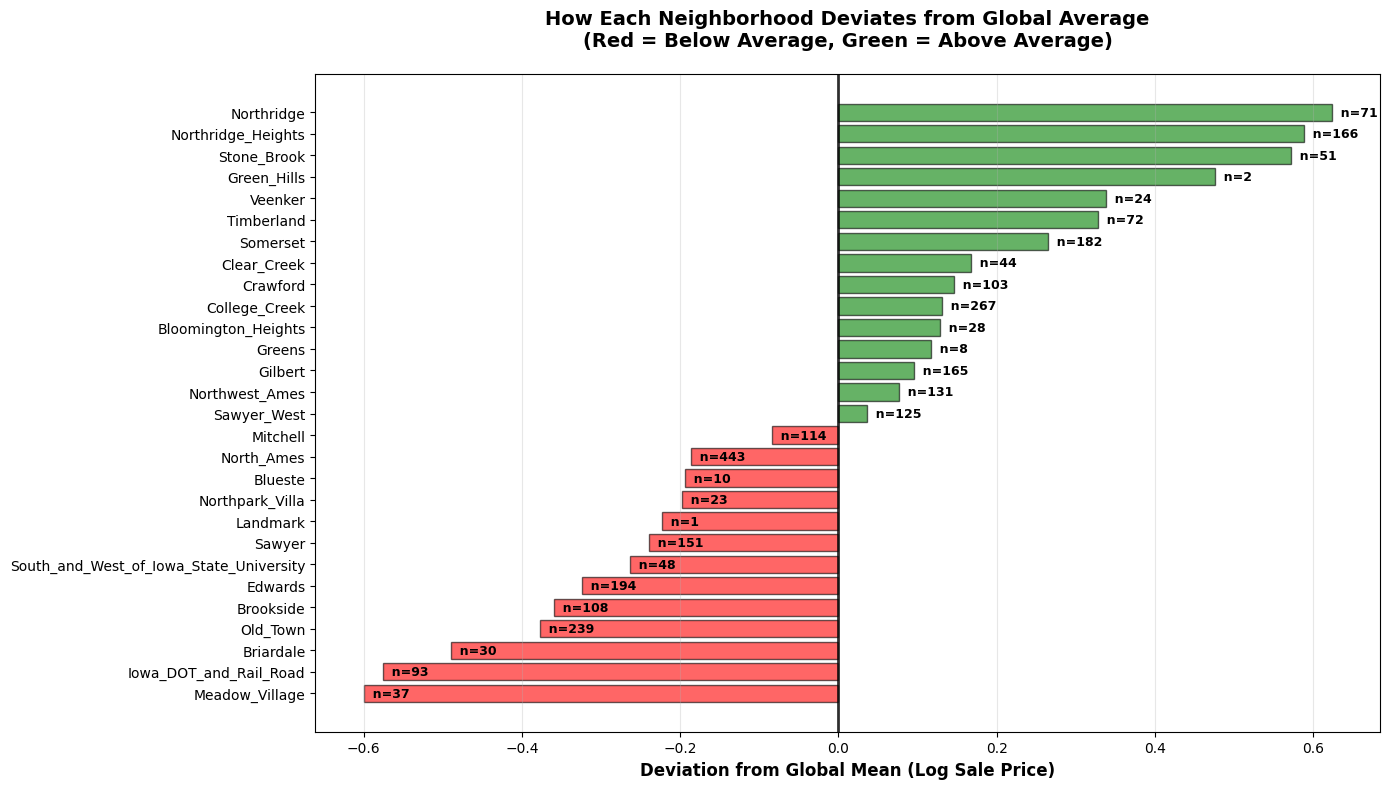

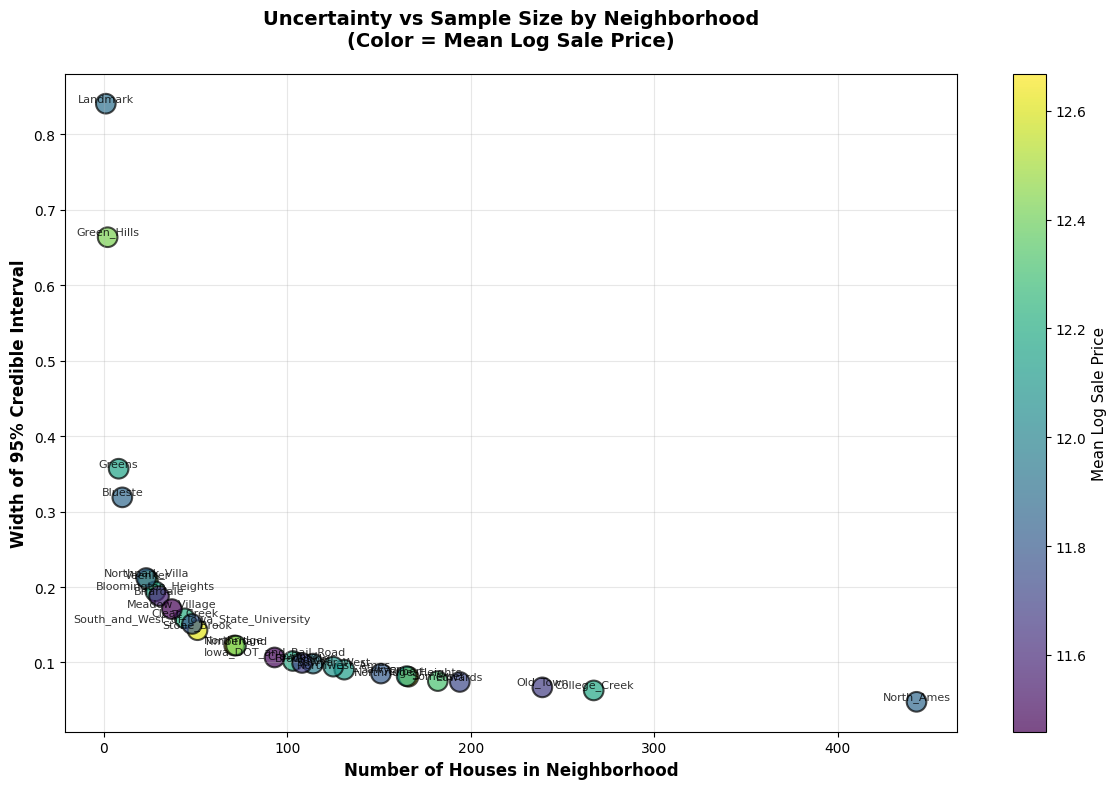

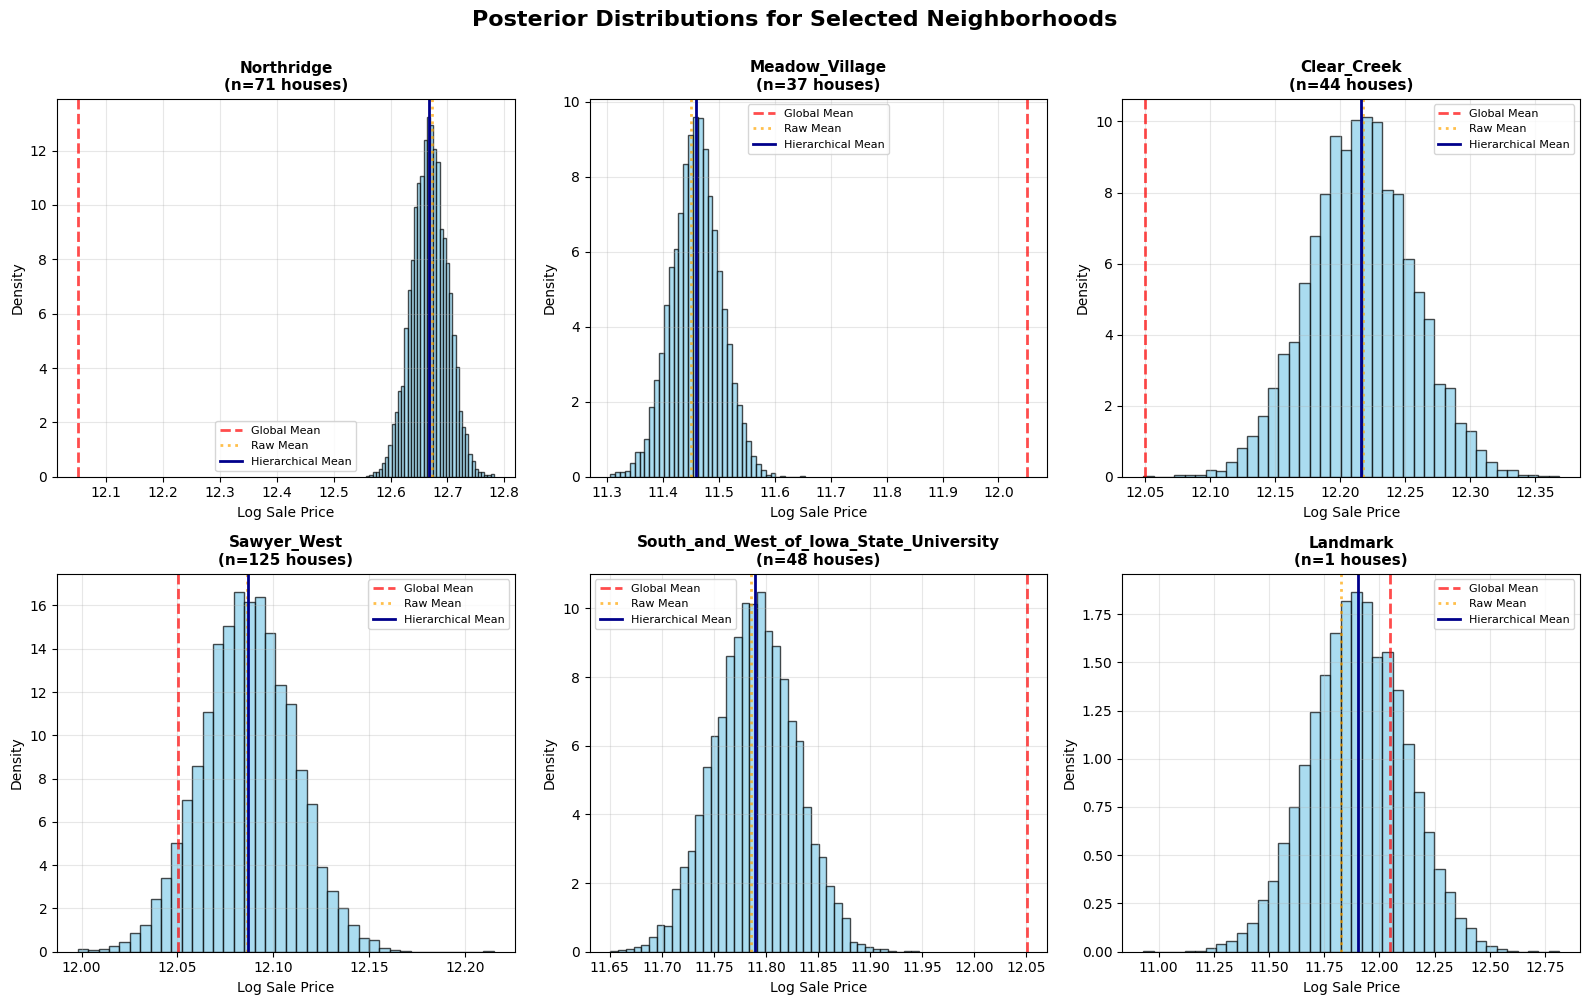

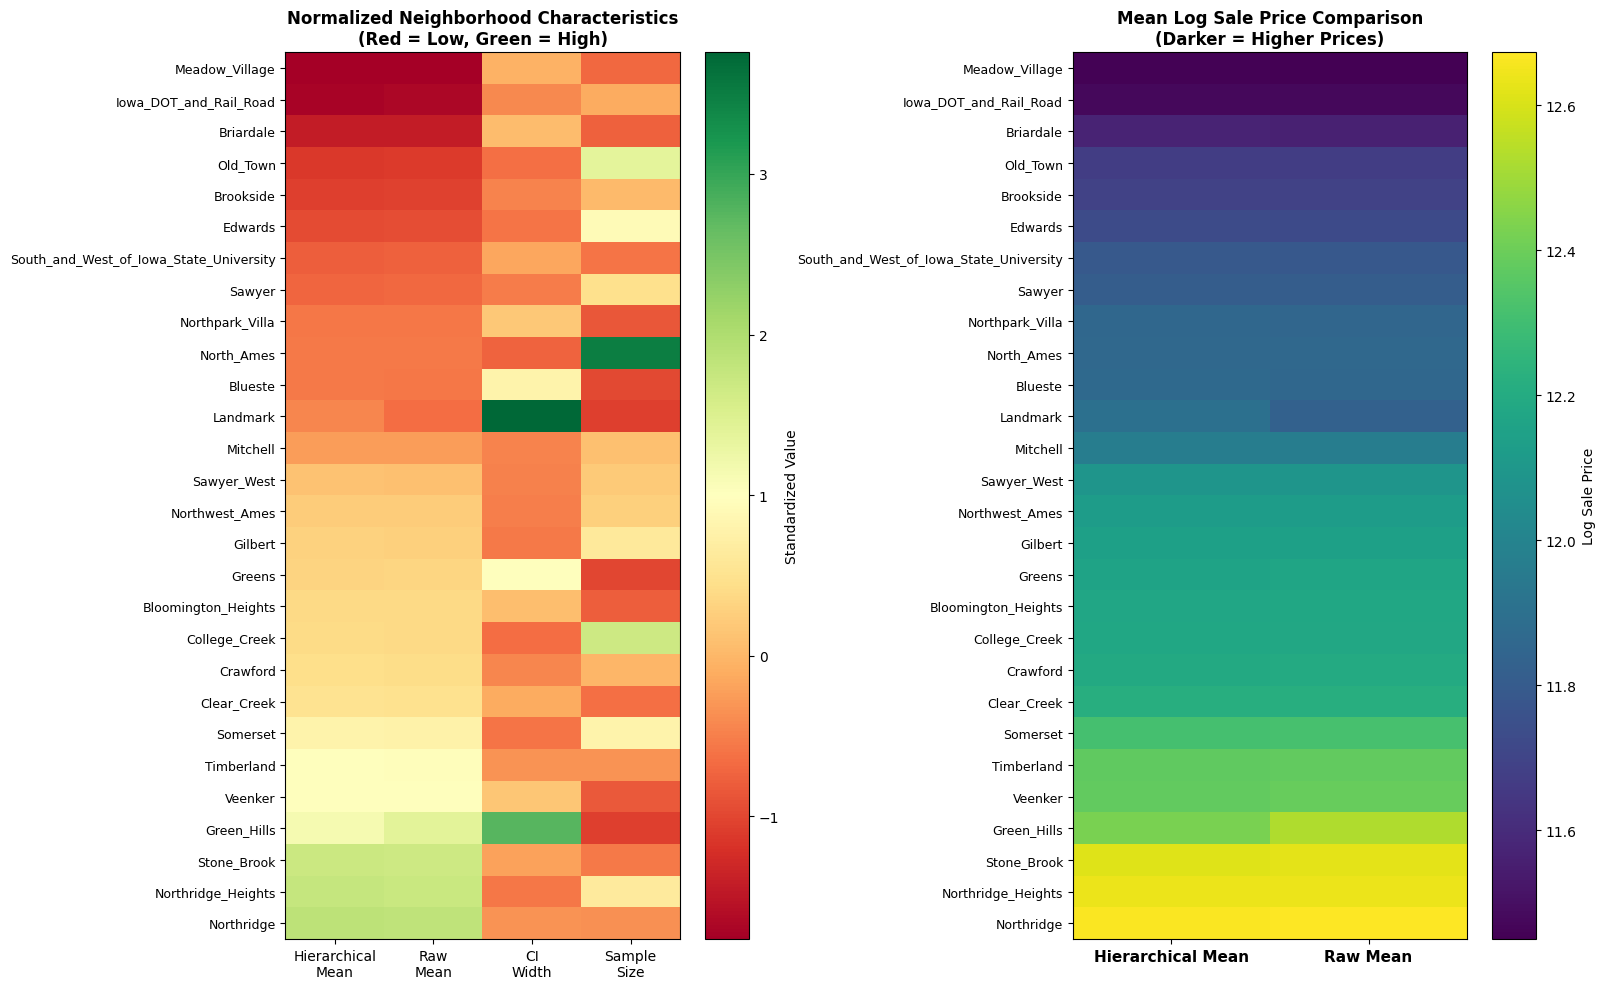


=== KEY INSIGHTS ===
Most Expensive Neighborhood: Northridge (Mean: 12.6682)
Least Expensive Neighborhood: Meadow_Village (Mean: 11.4586)
Price Range: 1.2096 log units
Most Certain Estimate: North_Ames (CI Width: 0.0478)
Least Certain Estimate: Landmark (CI Width: 0.8406)


In [5]:
from sklearn.preprocessing import StandardScaler

mu_post_mean = np.mean(mu_post)

# --- Comprehensive Neighborhood Analysis ---

# Calculate key statistics for each neighborhood
neighborhood_stats = pd.DataFrame({
    'Neighborhood': neighborhood_names,
    'Raw_Mean': y_bar_j,
    'Hierarchical_Mean': np.mean(theta_j_post, axis=0),
    'Num_Houses': n_j,
    'Hierarchical_SD': np.std(theta_j_post, axis=0),
    'Deviation_from_Global': y_bar_j - mu_post_mean
})

# Add credible intervals
neighborhood_stats['CI_Lower'] = np.percentile(theta_j_post, 2.5, axis=0)
neighborhood_stats['CI_Upper'] = np.percentile(theta_j_post, 97.5, axis=0)
neighborhood_stats['CI_Width'] = neighborhood_stats['CI_Upper'] - neighborhood_stats['CI_Lower']

# Sort by hierarchical mean for better visualization
neighborhood_stats = neighborhood_stats.sort_values('Hierarchical_Mean', ascending=False)

print("=== Neighborhood Statistics Summary ===")
print(neighborhood_stats.to_string(index=False))
print(f"\nGlobal Mean (mu): {mu_post_mean:.4f}")
print(f"Between-neighborhood SD (tau): {np.mean(np.sqrt(tau2_post)):.4f}")
print(f"Within-neighborhood SD (sigma): {np.mean(np.sqrt(sigma2_post)):.4f}")

# --- PLOT 1: Forest Plot with Credible Intervals ---
fig, ax = plt.subplots(figsize=(12, 10))

y_pos = np.arange(len(neighborhood_stats))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(neighborhood_stats)))

# Plot credible intervals
for i, (idx, row) in enumerate(neighborhood_stats.iterrows()):
    ax.plot([row['CI_Lower'], row['CI_Upper']], [i, i], 
            color=colors[i], linewidth=2, alpha=0.7)
    ax.scatter(row['Hierarchical_Mean'], i, color=colors[i], s=100, zorder=3, edgecolors='black')
    ax.scatter(row['Raw_Mean'], i, color=colors[i], s=50, marker='x', zorder=3, alpha=0.6)

# Add global mean reference line
ax.axvline(mu_post_mean, color='red', linestyle='--', linewidth=2, label=f'Global Mean ({mu_post_mean:.2f})', alpha=0.7)

ax.set_yticks(y_pos)
ax.set_yticklabels(neighborhood_stats['Neighborhood'])
ax.set_xlabel('Log Sale Price', fontsize=12, fontweight='bold')
ax.set_title('Neighborhood Mean Estimates with 95% Credible Intervals\n(Circles = Hierarchical Estimates, X = Raw Means)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- PLOT 2: Deviation from Global Mean ---
fig, ax = plt.subplots(figsize=(14, 8))

sorted_by_deviation = neighborhood_stats.sort_values('Deviation_from_Global')
colors_deviation = ['red' if x < 0 else 'green' for x in sorted_by_deviation['Deviation_from_Global']]

bars = ax.barh(range(len(sorted_by_deviation)), sorted_by_deviation['Deviation_from_Global'], 
               color=colors_deviation, alpha=0.6, edgecolor='black')

# Add sample size annotations
for i, (idx, row) in enumerate(sorted_by_deviation.iterrows()):
    ax.text(row['Deviation_from_Global'], i, f"  n={int(row['Num_Houses'])}", 
            va='center', fontsize=9, fontweight='bold')

ax.axvline(0, color='black', linewidth=2, linestyle='-', alpha=0.8)
ax.set_yticks(range(len(sorted_by_deviation)))
ax.set_yticklabels(sorted_by_deviation['Neighborhood'])
ax.set_xlabel('Deviation from Global Mean (Log Sale Price)', fontsize=12, fontweight='bold')
ax.set_title('How Each Neighborhood Deviates from Global Average\n(Red = Below Average, Green = Above Average)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- PLOT 3: Sample Size vs Uncertainty (CI Width) ---
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(neighborhood_stats['Num_Houses'], neighborhood_stats['CI_Width'],
                     c=neighborhood_stats['Hierarchical_Mean'], cmap='viridis', 
                     s=200, alpha=0.7, edgecolors='black', linewidth=1.5)

# Add neighborhood labels
for idx, row in neighborhood_stats.iterrows():
    ax.annotate(row['Neighborhood'], 
                (row['Num_Houses'], row['CI_Width']),
                fontsize=8, ha='center', va='bottom', alpha=0.8)

ax.set_xlabel('Number of Houses in Neighborhood', fontsize=12, fontweight='bold')
ax.set_ylabel('Width of 95% Credible Interval', fontsize=12, fontweight='bold')
ax.set_title('Uncertainty vs Sample Size by Neighborhood\n(Color = Mean Log Sale Price)', 
             fontsize=14, fontweight='bold', pad=20)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Mean Log Sale Price', fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- PLOT 4: Posterior Distributions for Selected Neighborhoods ---
# Select 6 interesting neighborhoods: highest, lowest, and some in between
selected_neighborhoods = [
    neighborhood_stats.iloc[0]['Neighborhood'],  # Highest mean
    neighborhood_stats.iloc[-1]['Neighborhood'],  # Lowest mean
    neighborhood_stats.iloc[len(neighborhood_stats)//4]['Neighborhood'],
    neighborhood_stats.iloc[len(neighborhood_stats)//2]['Neighborhood'],
    neighborhood_stats.iloc[3*len(neighborhood_stats)//4]['Neighborhood'],
    neighborhood_stats[neighborhood_stats['Num_Houses'] == neighborhood_stats['Num_Houses'].min()]['Neighborhood'].values[0]  # Smallest sample
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, neigh in enumerate(selected_neighborhoods):
    idx = neighborhood_names.index(neigh)
    
    axes[i].hist(theta_j_post[:, idx], bins=40, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    axes[i].axvline(mu_post_mean, color='red', linestyle='--', linewidth=2, label='Global Mean', alpha=0.7)
    axes[i].axvline(y_bar_j[idx], color='orange', linestyle=':', linewidth=2, label='Raw Mean', alpha=0.7)
    axes[i].axvline(np.mean(theta_j_post[:, idx]), color='darkblue', linestyle='-', linewidth=2, 
                    label='Hierarchical Mean')
    
    axes[i].set_title(f'{neigh}\n(n={n_j[idx]} houses)', fontweight='bold', fontsize=11)
    axes[i].set_xlabel('Log Sale Price', fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].grid(alpha=0.3)

plt.suptitle('Posterior Distributions for Selected Neighborhoods', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# --- PLOT 5: Heatmap of Neighborhood Rankings ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

# Sort by hierarchical mean for heatmap
sorted_for_heatmap = neighborhood_stats.sort_values('Hierarchical_Mean', ascending=True)

# Create data matrix
data_matrix = sorted_for_heatmap[['Hierarchical_Mean', 'Raw_Mean', 'CI_Width', 'Num_Houses']].values

# Normalize each column for better visualization
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_matrix)

im1 = ax1.imshow(data_normalized, cmap='RdYlGn', aspect='auto')
ax1.set_xticks(range(4))
ax1.set_xticklabels(['Hierarchical\nMean', 'Raw\nMean', 'CI\nWidth', 'Sample\nSize'], fontsize=10)
ax1.set_yticks(range(len(sorted_for_heatmap)))
ax1.set_yticklabels(sorted_for_heatmap['Neighborhood'], fontsize=9)
ax1.set_title('Normalized Neighborhood Characteristics\n(Red = Low, Green = High)', 
              fontweight='bold', fontsize=12)
plt.colorbar(im1, ax=ax1, label='Standardized Value')

# Plot 2: Just the means comparison
means_data = sorted_for_heatmap[['Hierarchical_Mean', 'Raw_Mean']].values
im2 = ax2.imshow(means_data, cmap='viridis', aspect='auto')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Hierarchical Mean', 'Raw Mean'], fontsize=11, fontweight='bold')
ax2.set_yticks(range(len(sorted_for_heatmap)))
ax2.set_yticklabels(sorted_for_heatmap['Neighborhood'], fontsize=9)
ax2.set_title('Mean Log Sale Price Comparison\n(Darker = Higher Prices)', 
              fontweight='bold', fontsize=12)
plt.colorbar(im2, ax=ax2, label='Log Sale Price')

plt.tight_layout()
plt.show()

# --- Summary Statistics Table ---
print("\n=== KEY INSIGHTS ===")
print(f"Most Expensive Neighborhood: {neighborhood_stats.iloc[0]['Neighborhood']} (Mean: {neighborhood_stats.iloc[0]['Hierarchical_Mean']:.4f})")
print(f"Least Expensive Neighborhood: {neighborhood_stats.iloc[-1]['Neighborhood']} (Mean: {neighborhood_stats.iloc[-1]['Hierarchical_Mean']:.4f})")
print(f"Price Range: {neighborhood_stats.iloc[0]['Hierarchical_Mean'] - neighborhood_stats.iloc[-1]['Hierarchical_Mean']:.4f} log units")
print(f"Most Certain Estimate: {neighborhood_stats.loc[neighborhood_stats['CI_Width'].idxmin(), 'Neighborhood']} (CI Width: {neighborhood_stats['CI_Width'].min():.4f})")
print(f"Least Certain Estimate: {neighborhood_stats.loc[neighborhood_stats['CI_Width'].idxmax(), 'Neighborhood']} (CI Width: {neighborhood_stats['CI_Width'].max():.4f})")

### Visualizing the "Shrinkage" Effect

The most critical result of a hierarchical model is **shrinkage**. The plot below visualizes this phenomenon. The X-axis represents the raw sample mean of a neighborhood (what a naive model would believe). The Y-axis represents the Hierarchical Posterior Mean (what our model believes).

*   **Points on the diagonal:** Neighborhoods where the model trusts the raw data completely (usually high sample size).
*   **Points pulled toward the red line:** Neighborhoods where the model "shrinks" the estimate toward the global average (usually low sample size).

***

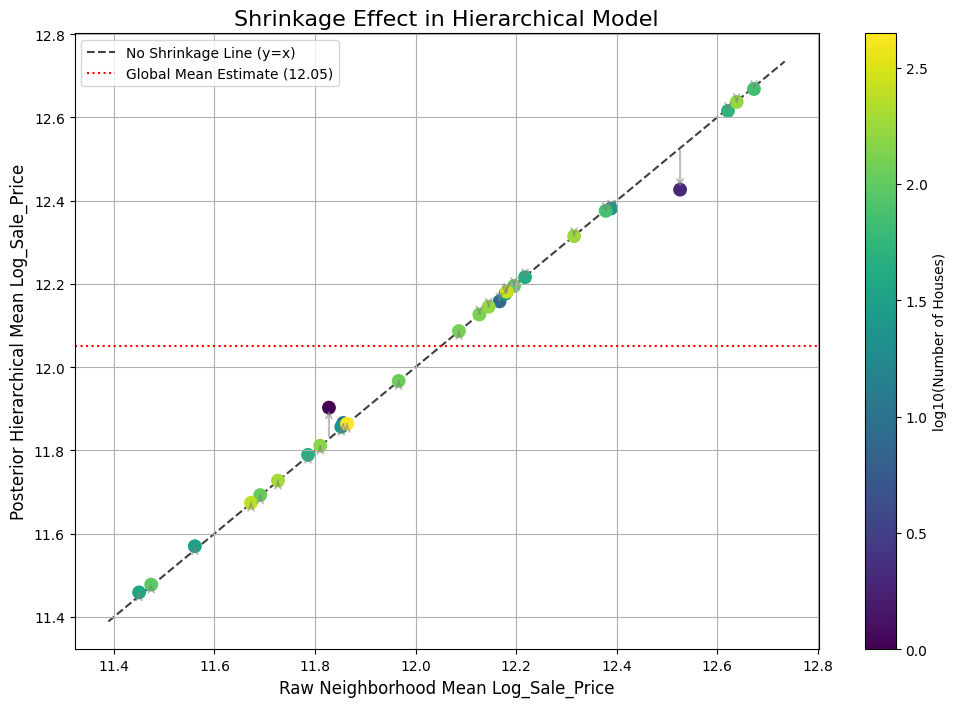

In [4]:
# We can visualize this by plotting the raw group means against the model's posterior estimates for those means.

# Calculate posterior means for each theta_j
theta_j_post_mean = np.mean(theta_j_post, axis=0)
mu_post_mean = np.mean(mu_post)

# Create a DataFrame for plotting
shrinkage_df = pd.DataFrame({
    'Neighborhood': neighborhood_names,
    'Raw_Mean': y_bar_j,
    'Hierarchical_Estimate': theta_j_post_mean,
    'Num_Houses': n_j
}).sort_values('Num_Houses')

# Shrinkage Plot
plt.figure(figsize=(12, 8))
plt.scatter(shrinkage_df['Raw_Mean'], shrinkage_df['Hierarchical_Estimate'], 
            c=np.log10(shrinkage_df['Num_Houses']), cmap='viridis', s=80)

# Add a y=x line for reference (no shrinkage)
lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='No Shrinkage Line (y=x)')
# Add arrows showing shrinkage direction
for i, row in shrinkage_df.iterrows():
    # The arrow STARTS on the y=x line (no shrinkage)
    start_point = (row['Raw_Mean'], row['Raw_Mean'])
    # The arrow ENDS at the actual data point
    end_point = (row['Raw_Mean'], row['Hierarchical_Estimate'])
    
    plt.annotate('', 
                 xy=end_point,          # Arrow tip (the colored dot)
                 xytext=start_point,    # Arrow base (on the y=x line)
                 arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5, lw=1.5))
# Add a horizontal line at the global mean
plt.axhline(mu_post_mean, color='red', linestyle=':', label=f'Global Mean Estimate ({mu_post_mean:.2f})')

plt.colorbar(label='log10(Number of Houses)')
plt.title('Shrinkage Effect in Hierarchical Model', fontsize=16)
plt.xlabel('Raw Neighborhood Mean Log_Sale_Price', fontsize=12)
plt.ylabel('Posterior Hierarchical Mean Log_Sale_Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Save the neighborhood stats dataframe to CSV
neighborhood_stats.to_csv(DATA_PATH / 'analysis' / 'hierarchical_stats.csv', index=False)
print(f"Hierarchical stats saved to 'hierarchical_stats.csv' in the analysis folder of {DATA_PATH}")

Hierarchical stats saved to 'hierarchical_stats.csv' in the analysis folder of /Users/Faheem/Desktop/IITH/Sem 5 Textbooks and Extras/Bayesian/Project 2/src/data


### Conclusion

This project successfully implemented a Hierarchical Bayesian Model for real estate valuation, demonstrating clear advantages over foundational approaches.

1.  **Robustness to Sparsity:** As seen in the `Landmark` and `Green_Hills` neighborhoods, the hierarchical model does not wildly overreact to small sample sizes. It "shrinks" these estimates toward the global mean, avoiding the overfitting traps of standard regression.
2.  **Uncertainty Quantification:** Unlike Ridge/Lasso, which provide point estimates, our Bayesian approach yields full posterior distributions. We can confidently say that `North_Ames` is more expensive than `Meadow_Village` not just by comparing means, but by observing non-overlapping credible intervals.
3.  **The Middle Ground:** The Hierarchical model strikes the optimal balance. It is not as rigid as the "Global Pooled" model (Red line in comparison plot) which ignores neighborhood value entirely, nor is it as volatile as the "Raw Mean" (Gray 'X') which overfits to local noise.

By leveraging **Partial Pooling**, we have constructed a valuation system that remains accurate for popular neighborhoods while providing safe, conservative estimates for rare ones.